# Visualization of a Simple Stochastic Gradient Descent running in Two Nodes

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla SGD, batch SGD and minibatch SGD. For this we consider a linear model with only two weights (the slope and the offset).

In [1]:
import ipcmagic
import ipyparallel as ipp

In [2]:
%ipcluster start -n 2 --mpi

IPCluster is ready! (4 seconds)


In [3]:
%%px
import socket
socket.gethostname()

Out[0:1]: 'nid06666'

Out[1:1]: 'nid06667'

In [4]:
%%px
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import horovod.tensorflow.keras as hvd

In [5]:
%%px
hvd.init()

In [6]:
%%px --target 0
tf.version.VERSION

Out[0:4]: '2.2.0'

In [7]:
%%px
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

In [8]:
%%px
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
# dataset = dataset.shard(2, hvd.rank())
dataset = dataset.shuffle(1000)
dataset = dataset.batch(100)
dataset = dataset.repeat(150)

In [9]:
%%px
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,), activation='linear'),
])

opt = tf.keras.optimizers.SGD(lr=0.5)
opt = hvd.DistributedOptimizer(opt)

model.compile(optimizer=opt,
              loss='mse')

In [10]:
%%px
class TrainHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.vars = []
        self.loss = []

    def on_batch_end(self, batch, logs={}):
        self.vars.append([v.numpy() for v in self.model.variables])
        self.loss.append(logs.get('loss'))
        
history = TrainHistory()

In [11]:
%%px
initial_sync = hvd.callbacks.BroadcastGlobalVariablesCallback(0)

In [12]:
%%px
fit = model.fit(dataset, callbacks=[history, initial_sync])

1500/1500 [==============================] - 8s 5ms/step - loss: 0.0843


[output:0]

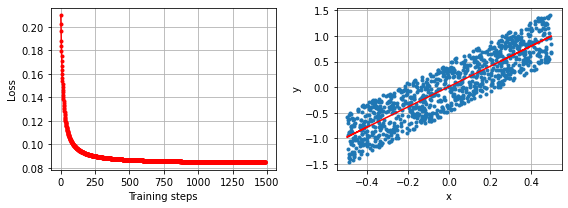

[output:1]

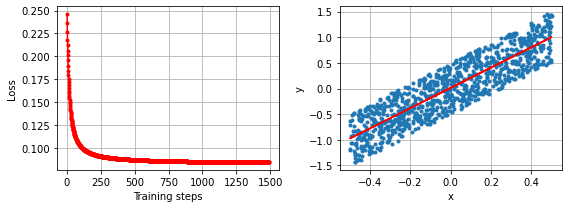

In [13]:
%%px
slope_hist = np.array(history.vars)[:, 0]
offset_hist = np.array(history.vars)[:, 1]
loss_hist = np.array(history.loss)

matplotlib.rcParams['figure.figsize'] = (8, 3)

plt.subplot(1, 2, 1)
plt.plot(loss_hist[10:], 'r.-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_train, y_train, '.')
plt.plot(x_train, slope_hist[-1] * x_train + offset_hist[-1], 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.tight_layout()
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

In [17]:
%%px
offset_hist

Out[0:15]: 
array([[0.0019221119582653046],
       [-0.023549817502498627],
       [-0.0038403160870075226],
       ...,
       [0.024064287543296814],
       [-0.02654711902141571],
       [0.013614386320114136]], dtype=object)

Out[1:14]: 
array([[0.0019221119582653046],
       [-0.023549817502498627],
       [-0.0038403160870075226],
       ...,
       [0.024064287543296814],
       [-0.02654711902141571],
       [0.013614386320114136]], dtype=object)

[output:0]

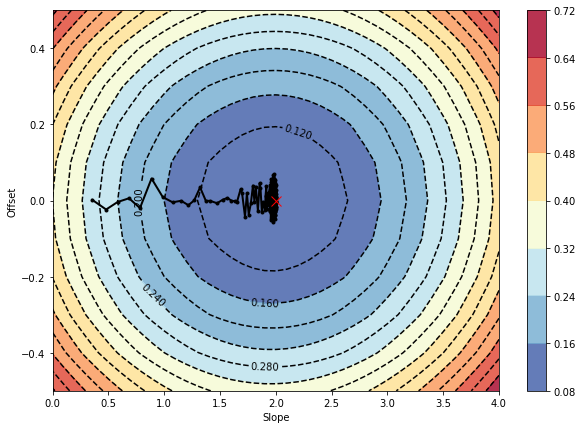

[output:1]

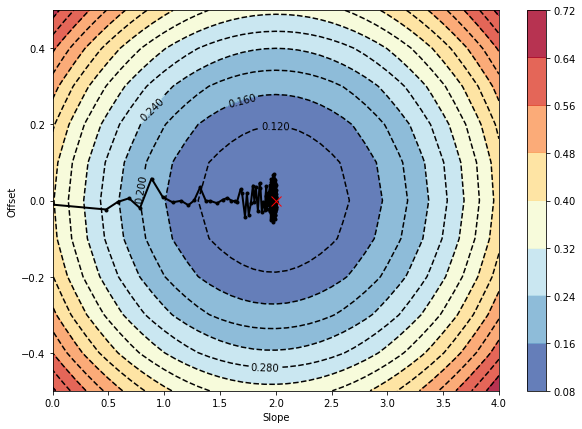

In [18]:
%%px
def loss_function_field(m, n, xref, yref):
    '''Utility function for ploting the loss'''
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange(-0.0, 4.01, 0.1)
_n = np.arange(-0.5, 0.51, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_train, y_train)

matplotlib.rcParams['figure.figsize'] = (10, 7)

cp = plt.contour(M, N, Z, 15, vmin=Z.min(), vmax=Z.max(), alpha=0.99, colors='k', linestyles='--')
plt.contourf(M, N, Z, vmin=Z.min(), vmax=Z.max(), alpha=0.8, cmap=plt.cm.RdYlBu_r)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot(slope_hist, offset_hist, '.-', lw=2, c='k')
plt.plot([ref_slope], [ref_offset], 'rx', ms=10)
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

In [19]:
%ipcluster stop